# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [39]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [40]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Tuesday-WorkingHours_training_80/result-lstm-tcp80-hl2-seq5-do0.2-oov1000-Thursday-WorkingHours_testing_80.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


/tmp/ipykernel_49270/1563370369.py:4: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv',


In [41]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.15-49439-131.253.61.98-80-tcp,0.104918,0,0,0,12348.233333,0,0,0
1,192.168.10.15-49442-23.60.139.27-80-tcp,0.077922,0,0,0,8175.331858,0,0,0
2,192.168.10.15-49441-23.63.226.146-80-tcp,0.084806,0,0,0,21189.902878,0,0,0
3,192.168.10.15-49448-23.15.4.16-80-tcp,0.104027,0,0,0,12774.936700,0,0,0
4,192.168.10.14-59146-72.21.91.29-80-tcp,0.030588,0,0,0,1608.919048,0,0,0


In [42]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148.0,192.168.10.50,22.0,6.0,6/7/2017 1:00,166.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.50,22.0,192.168.10.12,60148.0,6.0,6/7/2017 1:00,83.0,1.0,2.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,192.168.10.12-91.189.89.199-123-123-17,192.168.10.12,123.0,91.189.89.199,123.0,17.0,6/7/2017 1:00,99947.0,1.0,1.0,...,40.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
3,192.168.10.12-72.38.129.202-123-123-17,192.168.10.12,123.0,72.38.129.202,123.0,17.0,6/7/2017 1:00,37017.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 1:00,111161336.0,147.0,0.0,...,0.0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,BENIGN


## Exploratory Data Analysis

In [43]:
df_truth[[' Label']].value_counts()

 Label                     
BENIGN                         456752
Web Attack Â Brute Force        1507
Web Attack Â XSS                 652
Infiltration                       36
Web Attack Â Sql Injection        21
Name: count, dtype: int64

In [44]:
df_pred[['b_iqr']].value_counts()

b_iqr
0        24846
1          986
Name: count, dtype: int64

In [45]:
df_pred[['b_zscore']].value_counts()

b_zscore
0           24907
1             925
Name: count, dtype: int64

In [46]:
df_truth.isnull().sum()

Flow ID              288602
 Source IP           288602
 Source Port         288602
 Destination IP      288602
 Destination Port    288602
                      ...  
Idle Mean            288602
 Idle Std            288602
 Idle Max            288602
 Idle Min            288602
 Label               288602
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [47]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 80
df_truth = df_truth[(df_truth['Source_Port'] == 80) | (df_truth['Destination_Port'] == 80)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63887 entries, 9 to 458958
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      63887 non-null  object 
 1   Source_IP                    63887 non-null  object 
 2   Source_Port                  63887 non-null  int64  
 3   Destination_IP               63887 non-null  object 
 4   Destination_Port             63887 non-null  int64  
 5   Protocol                     63887 non-null  float64
 6   Timestamp                    63887 non-null  object 
 7   Flow_Duration                63887 non-null  float64
 8   Total_Fwd_Packets            63887 non-null  float64
 9   Total_Backward_Packets       63887 non-null  float64
 10  Total_Length_of_Fwd_Packets  63887 non-null  float64
 11  Total_Length_of_Bwd_Packets  63887 non-null  float64
 12  Fwd_Packet_Length_Max        63887 non-null  float64
 13  Fwd_Packet_Length_Mi

In [48]:
df_truth['Label'].head()

9     BENIGN
10    BENIGN
39    BENIGN
40    BENIGN
41    BENIGN
Name: Label, dtype: object

In [49]:
df_truth[['Label']].value_counts()

Label                      
BENIGN                         61707
Web Attack Â Brute Force       1507
Web Attack Â XSS                652
Web Attack Â Sql Injection       21
Name: count, dtype: int64

In [50]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_49270/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


In [52]:
sql_injection_ids = df_truth.loc[
    df_truth['Label'].astype(str).str.contains('Sql Injection', case=False, na=False),
    'id'
]
sql_injection_ids


378895    172.16.0.1-36196-192.168.10.50-80-tcp
378930    172.16.0.1-36196-192.168.10.50-80-tcp
378931    172.16.0.1-36198-192.168.10.50-80-tcp
378953    172.16.0.1-36198-192.168.10.50-80-tcp
378972    172.16.0.1-36200-192.168.10.50-80-tcp
379305    172.16.0.1-36200-192.168.10.50-80-tcp
379639    172.16.0.1-36202-192.168.10.50-80-tcp
379776    172.16.0.1-36202-192.168.10.50-80-tcp
380074    172.16.0.1-36204-192.168.10.50-80-tcp
380121    172.16.0.1-36204-192.168.10.50-80-tcp
380173    172.16.0.1-36206-192.168.10.50-80-tcp
380217    172.16.0.1-36206-192.168.10.50-80-tcp
381014    172.16.0.1-36208-192.168.10.50-80-tcp
381061    172.16.0.1-36208-192.168.10.50-80-tcp
381084    172.16.0.1-36210-192.168.10.50-80-tcp
381192    172.16.0.1-36212-192.168.10.50-80-tcp
381487    172.16.0.1-36214-192.168.10.50-80-tcp
381586    172.16.0.1-36242-192.168.10.50-80-tcp
381835    172.16.0.1-36244-192.168.10.50-80-tcp
381844    172.16.0.1-36242-192.168.10.50-80-tcp
381888    172.16.0.1-36244-192.168.10.50

## Making Predictions

In [53]:
df_pred["id"]

0         192.168.10.15-49439-131.253.61.98-80-tcp
1          192.168.10.15-49442-23.60.139.27-80-tcp
2         192.168.10.15-49441-23.63.226.146-80-tcp
3            192.168.10.15-49448-23.15.4.16-80-tcp
4           192.168.10.14-59146-72.21.91.29-80-tcp
                           ...                    
25827     192.168.10.14-52024-40.112.213.22-80-tcp
25828    192.168.10.51-44532-211.233.74.132-80-tcp
25829    192.168.10.51-44538-211.233.74.132-80-tcp
25830    192.168.10.51-44547-211.233.74.132-80-tcp
25831    192.168.10.51-44554-211.233.74.132-80-tcp
Name: id, Length: 25832, dtype: object

In [54]:
df_truth["id"]

9         192.168.10.15-55578-172.217.10.142-80-tcp
10        192.168.10.15-55581-172.217.10.142-80-tcp
39           72.21.91.29-80-192.168.10.15-55543-tcp
40           72.21.91.29-80-192.168.10.15-55480-tcp
41         23.210.202.27-80-192.168.10.15-55449-tcp
                            ...                    
458940      52.84.40.136-80-192.168.10.15-55570-tcp
458941      52.84.40.136-80-192.168.10.15-55571-tcp
458953       192.168.10.15-55480-72.21.91.29-80-tcp
458957       192.168.10.15-55543-72.21.91.29-80-tcp
458958       192.168.10.15-55544-72.21.91.29-80-tcp
Name: id, Length: 63887, dtype: object

In [55]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [56]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [57]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
1783,172.16.0.1-44380-192.168.10.50-80-tcp,0.115914,0,1,1,8581.437315,0,0,0,1
1784,172.16.0.1-44380-192.168.10.50-80-tcp,0.115914,0,1,1,8581.437315,0,0,0,1
1785,172.16.0.1-44382-192.168.10.50-80-tcp,0.129781,0,1,1,12130.441541,0,0,0,1
1786,172.16.0.1-44384-192.168.10.50-80-tcp,0.088083,0,0,0,7951.764583,0,0,0,1
1787,172.16.0.1-44386-192.168.10.50-80-tcp,0.086687,0,0,0,7773.001037,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
15241,172.16.0.1-49362-192.168.10.50-80-tcp,0.178720,0,1,1,28860.177796,0,0,0,1
15402,172.16.0.1-49502-192.168.10.50-80-tcp,0.188034,1,1,1,31296.008621,1,1,1,1
15403,172.16.0.1-49502-192.168.10.50-80-tcp,0.188034,1,1,1,31296.008621,1,1,1,1
15406,172.16.0.1-49522-192.168.10.50-80-tcp,0.169231,0,1,1,28889.406250,0,0,0,1


In [58]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.15-49439-131.253.61.98-80-tcp,0.104918,0,0,0,12348.233333,0,0,0,0
1,192.168.10.15-49439-131.253.61.98-80-tcp,0.104918,0,0,0,12348.233333,0,0,0,0
2,192.168.10.15-49442-23.60.139.27-80-tcp,0.077922,0,0,0,8175.331858,0,0,0,0
3,192.168.10.15-49442-23.60.139.27-80-tcp,0.077922,0,0,0,8175.331858,0,0,0,0
4,192.168.10.15-49441-23.63.226.146-80-tcp,0.084806,0,0,0,21189.902878,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
47328,192.168.10.51-44538-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0
47329,192.168.10.51-44547-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0
47330,192.168.10.51-44547-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0
47331,192.168.10.51-44554-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0


In [73]:
count = df_pred[df_pred["id"] == "172.16.0.1-36244-192.168.10.50-80-tcp"]

print(count)

                                          id  binary_error  b_mean  b_iqr  \
13043  172.16.0.1-36244-192.168.10.50-80-tcp      0.068908       0      0   
13044  172.16.0.1-36244-192.168.10.50-80-tcp      0.068908       0      0   

       b_zscore  floatin_error  f_mean  f_iqr  f_zscore  Label  
13043         0     7559.90339       0      0         0      1  
13044         0     7559.90339       0      0         0      1  


In [59]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.15-49439-131.253.61.98-80-tcp,0.104918,0,0,0,12348.233333,0,0,0,0
1,192.168.10.15-49439-131.253.61.98-80-tcp,0.104918,0,0,0,12348.233333,0,0,0,0
2,192.168.10.15-49442-23.60.139.27-80-tcp,0.077922,0,0,0,8175.331858,0,0,0,0
3,192.168.10.15-49442-23.60.139.27-80-tcp,0.077922,0,0,0,8175.331858,0,0,0,0
4,192.168.10.15-49441-23.63.226.146-80-tcp,0.084806,0,0,0,21189.902878,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
47328,192.168.10.51-44538-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0
47329,192.168.10.51-44547-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0
47330,192.168.10.51-44547-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0
47331,192.168.10.51-44554-211.233.74.132-80-tcp,0.058350,0,0,0,18642.930894,0,0,0,0


In [60]:
df_pred[['Label']].value_counts()

Label
0        46948
1          385
Name: count, dtype: int64

In [61]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [62]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [63]:
df_pred[['b_zscore']]

,b_zscore
0,0
1,0
2,0
3,0
4,0
...,...
47328,0
47329,0
47330,0
47331,0


### Detection Rate

In [64]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.005194805194805195
Recall-Binary-b_iqr: 0.06753246753246753
Recall-Binary-b_zscore: 0.05714285714285714
Recall-Floating-f_mean: 0.005194805194805195
Recall-Floating-f_iqr: 0.005194805194805195
Recall-Floating-f_zscore: 0.005194805194805195


### Confussion Matrix

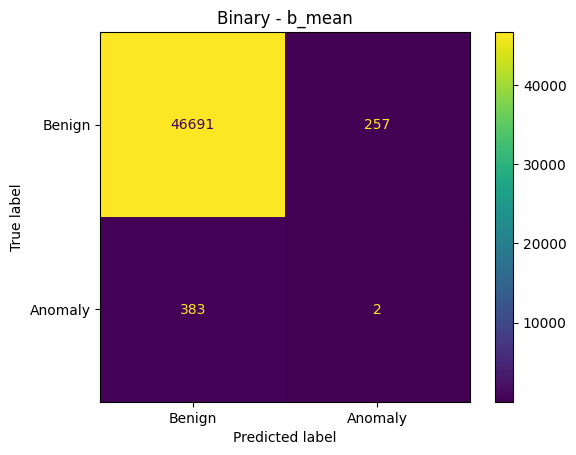

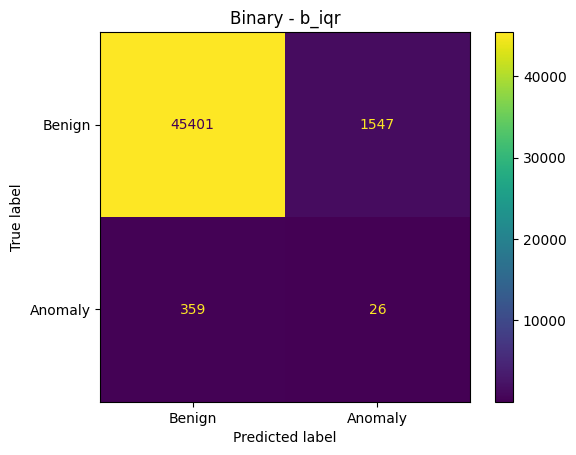

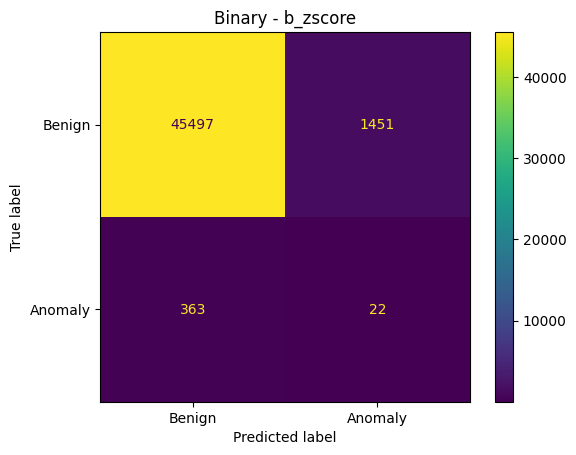

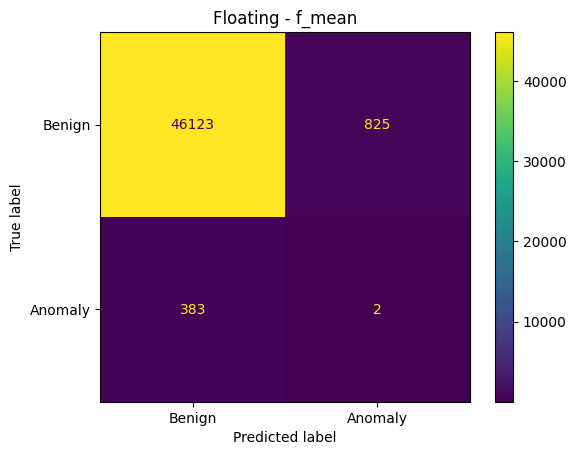

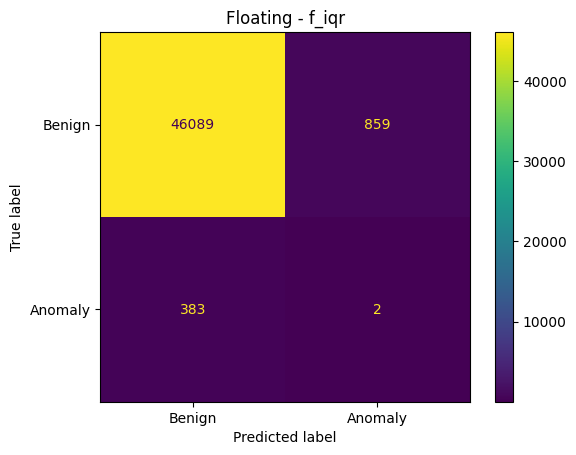

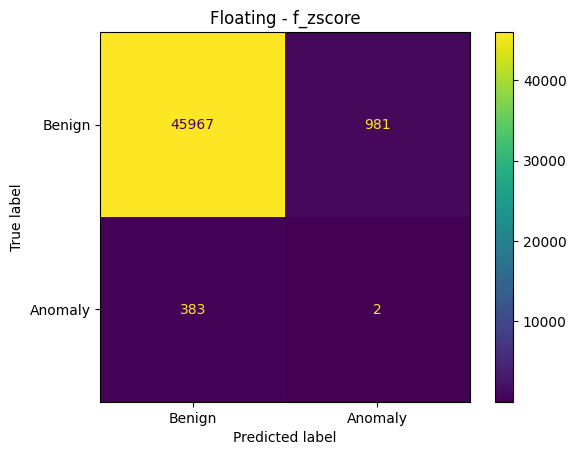

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [66]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.005558643690939411
F2-Binary-b_iqr: 0.041760359781561195
F2-Binary-b_zscore: 0.036508463325589116
F2-Floating-f_mean: 0.004224757076468103
F2-Floating-f_iqr: 0.004164931278633903
F2-Floating-f_zscore: 0.003963535473642489


### FPR Score

In [67]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.005474141603476187
FPR-Binary-b_iqr: 0.03295135043026327
FPR-Binary-b_zscore: 0.03090653488966516
FPR-Floating-f_mean: 0.017572633552014997
FPR-Floating-f_iqr: 0.018296839055976826
FPR-Floating-f_zscore: 0.020895458805486922


In [68]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.9864787780195635
Accuracy-Binary-b_iqr: 0.9597321107895126
Accuracy-Binary-b_zscore: 0.9616757864492004
Accuracy-Floating-f_mean: 0.9744786935119262
Accuracy-Floating-f_iqr: 0.9737603785942155
Accuracy-Floating-f_zscore: 0.9711828956541948


In [69]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.005195,0.005559,0.005474,0.986479
b_iqr,0.067532,0.041760,0.032951,0.959732
b_zscore,0.057143,0.036508,0.030907,0.961676
f_mean,0.005195,0.004225,0.017573,0.974479
f_iqr,0.005195,0.004165,0.018297,0.973760
f_zscore,0.005195,0.003964,0.020895,0.971183


In [70]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [71]:
# %pip install openpyxl